## Finite Differences to Price American Options

This notebook explains how finite differences are used to price American Style Options.

## FD

There are three main ways to compute finite differences. An explicit discretization scheme, an implicit discretization scheme, and the Crank-Nicholson scheme.

#### Explicit

There are three main characteristics of explicit discretization.

1. Uses forward difference approximations.

2. Derives the PDE value (solution) at each point on current time slice from points at the previous time slice independent of any points in the current time slice.

3. It is conditionally stable: $0 <  \delta t < \frac{(\delta x)^2}{2 \kappa}$ is the stability condition for equations of the form $ u_t - \kappa u_xx = 0 $. The BSM PDE can be transformed to have this form and we can get values for $ \kappa $


#### Implicit

There are three main characteristics of implicit discretization.

1. Uses backward difference approximations in time, and central approximations for space (within the time slice).

2. Derives the PDE value (solution) for all points on the current time slice simultaneously as they are interdependent

3. It is unconditionally stable.


#### CN

There are three main characteristics of implicit discretization.

1. Uses central difference approximations in time, and the average of two central approximations for space (within the time slice).

2. Derives the PDE value (solution) for all points on the current time slice simultaneously as they are interdependent.

3. It is unconditionally stable.



The generalized difference formula, in matrix notation, is 

$U_{k+1} = B U_k$.

For explicit, $B = A_{explicit}$, i.e. $U_{k+1} = A_{E} U_k$.

For implicit, $B = A_{implicit}^{-1}$, i.e. $A_{I}U_{k+1} = U_{k}$

For Crank Nicholson, $B = (A_I + I)^{-1}(A_E + I)$, i.e. $ (A_{I} + I)U_{k+1} = (A_{E} + I)U_k $

For this sample, we will use a tridiagonal matrix solver. The other option would be a pentadiagonal solver, but this is a more involved set up. We will compare an American style Call and an American style Put.

References: *Computational Methods in Finance*, Hirsa. My code has been modified from some code obtained from this book.

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import BMS

#For using in a script.
#startTime = time.time()


def tridiagSolver(l, d, u, f):
    
    ''' 
    Tridiagonal solver 
    '''
    
    n = len(f)
    v = np.zeros(n)
    y = np.zeros(n)
    w = d[0]
    y[0] = 1.0 * f[0] / w
    
    for i in range(1, n):
        v[i-1] = 1. * u[i-1] / w
        w = d[i] - l[i] * v[i-1]
        y[i] = 1. * (f[i] - l[i] * y[i-1]) / w
    
    for j in range(n-2, -1, -1):
        y[j] = y[j] - v[j] * y[j+1]
    
    return y

In [3]:

type_option = 'american'
#type_option = 'european'

## We can choose which PDE boundary conditions to use. This will result in minor differences

boundary = 'neumann'
#boundary = 'dirichlet'

#scenario. These parameters just result in different graphs.
scenario = '1'

if scenario == '1':
    r = 0.0541
    q = 0.012
elif scenario == '2':
    r = 0.01
    q = 0.1


S = 1000
K = 1300

sig = 0.3
T = 1

# 0,1,2,...,N,N+1

sMin = 100
sMax = 2000

N = 1000
M = 365

#Compute the increment parameters
dS = (sMax - sMin) / N
dT = T / M

s = np.zeros(N-1)
tau = np.zeros(M)

l = np.zeros(N-1)
u = np.zeros(N-1)
d = np.zeros(N-1)

vCall = np.zeros(N-1)
vPut = np.zeros(N-1)

#These are the values that we will be using for our tridiagonal solver
alpha = 0.5 * (sig ** 2) * dT / (dS ** 2)
beta = (r - q) * dT / (2.0 * dS)

# tridiagonal matrix construction
s = sMin + np.arange(1, N) * dS
l = -alpha * (s ** 2) + beta * s
l[0] = 0
d = 1 + r * dT + 2 * alpha * (s ** 2)
u = -alpha * (s ** 2) - beta * s
u[-1] = 0

#If we use dirichlet, we need to explicitly define the values differently
if boundary == 'neumann':
    l[-1] = 2 * beta * s[-1]
    d[0] = 1 + r * dT + 2 * beta * s[0]
    d[-1] = 1 + r * dT - 2 * beta * s[-1]
    u[0] = -2 * beta * s[0]
    
# exercise boundaries
if type_option == 'american':
    SxCall = np.zeros(M)
    SxPut = np.zeros(M)

tau = dT * np.arange(1, M+1)

In [4]:
print('type_option = ' + str(type_option))
print ('boundary_conditions = ' + str(boundary))

vCall = np.maximum(s - K, 0)
vPut = np.maximum(K - s, 0)
for j in range(M):
    # print progress
    if (j+1) % 50 == 0:
        print('iter = ' + str(j+1))
    ######################
    # calls
    if boundary == 'dirichlet':
        if type_option == 'american':
            tmp_pay = sMax - K
        else:
            tmp_pay = sMax*np.exp(-r*dT*j) - K*np.exp(-q*dT*j)
        vCall[-1] -= tmp_pay * (-alpha * (sMax ** 2) - beta * sMax)
    vCall = tridiagSolver(l, d, u, vCall)
    if type_option == 'american':
        flagC = 0
        for i in range(N-2, -1, -1):
            # exercise boundary
            if (flagC == 0) and (vCall[i] > np.maximum(s[i] - K, 0)):
                SxCall[j] = s[i]
                flagC = 1
            # premium
            if vCall[i] <= np.maximum(s[i] - K, 0):
                vCall[i] = np.maximum(s[i] - K, 0)
    # puts
    if boundary == 'dirichlet':
        if type_option == 'american':
            tmp_pay = K - sMin
        else:
            tmp_pay = K*np.exp(-q*dT*j) - sMin*np.exp(-r*dT*j)
        vPut[0] -= tmp_pay * (-alpha * (sMin ** 2) + beta * sMin)
    vPut = tridiagSolver(l, d, u, vPut)
    if type_option == 'american':
        flagP = 0
        for i in range(N-1):
            # exercise boundary
            if (flagP == 0) and (vPut[i] > np.maximum(K - s[i], 0)):
                SxPut[j] = s[i]
                flagP = 1
            # premium
            if vPut[i] <= np.maximum(K - s[i], 0):
                vPut[i] = np.maximum(K - s[i], 0)
print('Done')

type_option = american
boundary_conditions = neumann
iter = 50
iter = 100
iter = 150
iter = 200
iter = 250
iter = 300
iter = 350
Done


In [5]:
# one spot price
call_fd = np.interp(S, s, vCall)
put_fd = np.interp(S, s, vPut)

callEuropean = BMS.BMS_price('call', S, K, r, q, sig, T)
putEuropean = BMS.BMS_price('put', S, K, r, q, sig, T)

print('European call (BMS): ' + str(callEuropean))
if type_option == 'american':
    print('American call (FD): ' + str(call_fd))
else:
    print('European call (FD): ' + str(call_fd))
    
print('European put (BMS): ' + str(putEuropean))
if type_option == 'american':
    print('American put (FD): ' + str(put_fd))
else:
    print('European put (FD): ' + str(put_fd))
    
# all spot prices
eCall = BMS.BMS_price('call', s, K, r, q, sig, T)
ePut = BMS.BMS_price('put', s, K, r, q, sig, T)

European call (BMS): 44.31692885015838
American call (FD): 44.303053903897485
European put (BMS): 287.783794424824
American put (FD): 310.6164284680763


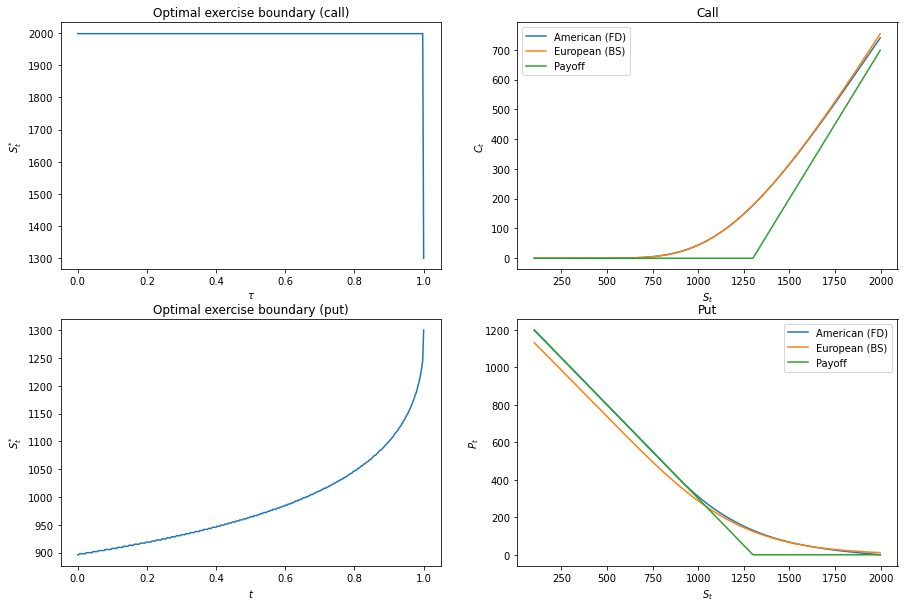

In [6]:
if type_option == 'american':
    plt.figure(figsize=(15,10))

    plt.subplot(2,2,1)
    tmp = np.sort(np.append(K, SxCall))[::-1]
    plt.plot(np.append(0,tau), tmp)
    plt.xlabel('$\\tau$')
    plt.ylabel('$S^{*}_t$')
    plt.title('Optimal exercise boundary (call)')

    plt.subplot(2,2,2)
    plt.plot(s, vCall)
    plt.plot(s, eCall)
    plt.plot(s, np.maximum(s-K, 0))
    plt.xlabel('$S_t$')
    plt.ylabel('$C_t$')
    plt.title('Call')
    plt.legend(['American (FD)', 'European (BS)', 'Payoff'])

    # calendar time as opposed to time-to-maturity
    plt.subplot(2,2,3)
    tmp = np.sort(np.append(K, SxPut))
    plt.plot(np.append(0,tau), tmp)
    plt.xlabel('$t$')
    plt.ylabel('$S^{*}_t$')
    plt.title('Optimal exercise boundary (put)')

    plt.subplot(2,2,4)
    plt.plot(s, vPut)
    plt.plot(s, ePut)
    plt.plot(s, np.maximum(K-s, 0))
    plt.xlabel('$S_t$')
    plt.ylabel('$P_t$')
    plt.title('Put')
    plt.legend(['American (FD)', 'European (BS)', 'Payoff'])
else:
    plt.figure(figsize=(15,5))
    
    plt.subplot(1,2,1)
    plt.plot(s, vCall)
    plt.plot(s, eCall)
    plt.plot(s, np.maximum(s-K, 0))
    plt.xlabel('$S_t$')
    plt.ylabel('$C_t$')
    plt.title('Call')
    plt.legend(['European (FD)', 'European (BS)', 'Payoff'])
    
    plt.subplot(1,2,2)
    plt.plot(s, vPut)
    plt.plot(s, ePut)
    plt.plot(s, np.maximum(K-s, 0))
    plt.xlabel('$S_t$')
    plt.ylabel('$P_t$')
    plt.title('Put')
    plt.legend(['European (FD)', 'European (BS)', 'Payoff'])


plt.show()
#plt.savefig('options_via_fd.pdf')

### Analysis

#### Note: A strike of 1300 and a starting price of 1000 was chosen.

What we see is very itneresting. Let's start with the bottom left plot, as it's fairly easy to understand. As calendar time increases from left to right, the critical price (the value below which the option should be early exercised) increases. This makes sense intuitively. If the maturity of a stock is near, then there is less risk involved in waiting for the option to mature. So it makes sense that the spot price wouldn't need to be very low to induce an early exercise. However, if we are early in the options life, given how much time we have, the spot price would need to be substantially low for us to early exercise.

The bottom right plot shows the value of the put with respect to the stock price. The green curve shows the payoff curve, which has a kink at the strike price, 1300, which is expected.

What we see is that when the stock price is below the kink, the American price and the payoff curves converge. The American is more valuable than the European in this region, because we are able to early exercise it. However, above the strike, the put is worthless, and so the European and the American option prices converge. They both converge to a positive value, which represents the time value of the option.

The analysis for calls are different. Note the top left plot. The early exercise boundary is frozen at 1998.1. Why? Note that with our parameter choice, the call options are significantly out of the money. So we would not be early exercising at all unless the stock value was significantly high. This is why in the top right plot, the values of the American and the European are nearly identical. The premium that is placed for an early exercise for this option is worthless.